In [2]:
import matplotlib.pylab as pylab
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from mlflow.tracking.client import MlflowClient


import sys
import yaml
sys.path.append("../")
%matplotlib inline

mlflow_params = yaml.load(open("../conf/base/mlflow.yml", "rb"))


plot_params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 20,
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}


pylab.rcParams.update(plot_params)

mlflow_client = MlflowClient(tracking_uri=mlflow_params["server"]["mlflow_tracking_uri"])
runs = mlflow_client.search_runs(experiment_ids=["1"])
print(len(runs), " runs found.")

7  runs found.


## Loading data from ML Flow tracking server
We use the ML Flow interface to retrieve the results of experiments.

In [3]:
def load_mlflow_artifact(filename):
    return pd.read_parquet(
        f".{run.info.artifact_uri}/{filename}",
    )

In [9]:
metrics = pd.DataFrame()
shift_detection_scores = pd.DataFrame()

# Loop over all experiment runs (one per model)
for i, run in enumerate(runs):
    model_name = run.data.params["model_name"]

    _metrics = run.data.metrics
    _metrics["Model"] = model_name
    
    metrics = metrics.append(_metrics, ignore_index=True)

    concept_shift_scores = load_mlflow_artifact("concept_shift_detection_scores.parquet")
    concept_shift_scores["Shift Type"] = "Concept"
    concept_shift_scores = concept_shift_scores.set_index("Shift Type", append=True)

    covariate_shift_scores = load_mlflow_artifact("covariate_shift_detection_scores.parquet")
    covariate_shift_scores["Shift Type"] = "Covariate"
    covariate_shift_scores = covariate_shift_scores.set_index("Shift Type", append=True)

    shift_scores = pd.concat(
        [concept_shift_scores, covariate_shift_scores],
        ignore_index=False
    )
    shift_scores["Model"] = model_name

    shift_detection_scores = shift_detection_scores.append(shift_scores)


shift_detection_scores["Model"]  = pd.Categorical(
    shift_detection_scores["Model"], 
    categories=["PPCA32", "LinearVAE", "SparsePCA32", "PPCA16", "LassoVAE","SparseVAE", "SparsePCA16"],
    ordered=True
)
shift_detection_scores = shift_detection_scores.set_index("Model", append=True, drop=True)
shift_detection_scores.index = shift_detection_scores.index.reorder_levels(["Shift Type", "Model", "N Samples"])
metrics["Model"]  = pd.Categorical(
    metrics["Model"], 
    categories=["LinearVAE", "PPCA32", "PPCA16", "SparsePCA32", "LassoVAE","SparseVAE", "SparsePCA16"],
    ordered=True
)

After aggregation of all results we get the following tables:

In [10]:
metrics

,MSE,latent_dim_pred,MAE_test,MSE_test,beta,l1_decoder,MAE,mapping_recovery_score,Model
0,0.044431,16.0,0.140135,0.031251,1.0,0.00,0.168369,0.987500,SparseVAE
1,0.077442,15.0,0.172147,0.075901,0.2,0.06,0.177070,0.648357,LassoVAE
2,0.038691,16.0,0.131935,0.028122,0.5,0.00,0.156528,0.160521,LinearVAE
3,0.030245,NaN,0.012287,0.080372,NaN,NaN,0.136478,0.259581,PPCA32
4,0.032390,NaN,0.012225,0.079789,NaN,NaN,0.141219,0.366152,PPCA16
5,0.020037,NaN,0.020015,0.106565,NaN,NaN,0.100577,0.480394,SparsePCA32
6,0.030220,NaN,0.010082,0.076342,NaN,NaN,0.137341,0.987500,SparsePCA16


In [11]:
shift_detection_scores

Gaussian Noise Std                     0.0       0.1       0.2       0.5  \
Shift Type Model       N Samples                                           
Concept    SparseVAE   20         1.248435  1.079555  0.788339  2.315756   
                       40         1.251102  1.084809  0.681997  2.361803   
                       80         1.253884  1.085613  0.587940  2.359328   
                       160        1.270382  1.098412  0.517603  2.372339   
                       320        1.252014  1.081031  0.460090  2.351396   
...                                    ...       ...       ...       ...   
Covariate  SparsePCA16 20         1.446382  1.450130  1.454677  1.483106   
                       40         1.261228  1.273215  1.285642  1.338817   
                       80         1.051227  1.066133  1.082781  1.142728   
                       160        0.872680  0.882427  0.890696  0.929586   
                       320        0.668644  0.676244  0.683990  0.744216   

Gaussian Noise Std                     1.0  
Shift Type Model       N Samples            
Concept    SparseVAE   20         3.208626  
                       40         3.296200  
                       80         3.322953  
                       160        3.331242  
                       320        3.319667  
...                                    ...  
Covariate  SparsePCA16 20         1.608862  
                       40         1.480744  
                       80         1.340861  
                       160        1.151900  
                       320        1.090204  

[70 rows x 5 columns]

## Results
### Covariate Shift Dispersion Score
 Measure the isolation of the true direction of the unitary shifts applied to the latent space. Lowest values mean a better isolation of the true source of shift. Each boxplot shows the distribution of the SDS for various values of batch size: $N_{\text{batch}}$ in $[20, 40, 80, 160, 320]$ and gaussian noise intensity: $\sigma^{noise}_{\text{batch}}$ in $[0.0, 0.1, 0.2, 0.5, 1]$}

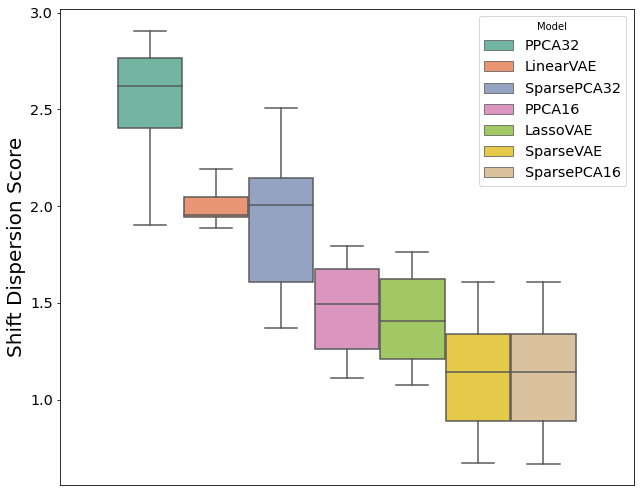

In [12]:
covariate_shift_detection_scores = shift_detection_scores.loc["Covariate"].melt(
    value_vars=shift_detection_scores.columns,
    var_name="Gaussian Noise Std",
    value_name="Shift Dispersion Score",
    ignore_index=False
)

covariate_shift_detection_scores["Gaussian Noise Std"] = covariate_shift_detection_scores["Gaussian Noise Std"].astype(float)

covariate_shift_detection_scores.name = "Average Shift Dispersion Score"
shift_detection_scores_melt = covariate_shift_detection_scores.reset_index()

covariate_shift_detection_scores["x"] = np.ones(len(covariate_shift_detection_scores))
plt.figure(figsize=(9, 7))
g = sns.boxplot(
    data=covariate_shift_detection_scores.reset_index(),
    x="x", y="Shift Dispersion Score", fliersize=0,
    hue="Model", palette="Set2"
)
g.axes.get_xaxis().set_visible(False)
plt.tight_layout()
g.get_figure().savefig("figures/shift_aggregated_scores.pdf")

### Mapping Recovery Scores
Mapping Recovery Scores of all models tested in this study. We see the superiority of of sparse models LassoVAE, SparseVAE and SparcePCA16 for this task. Note that without the correct number of latent factors the Sparse PCA do not recover the true mapping, as shown by the poorer performace of SparsePCA32

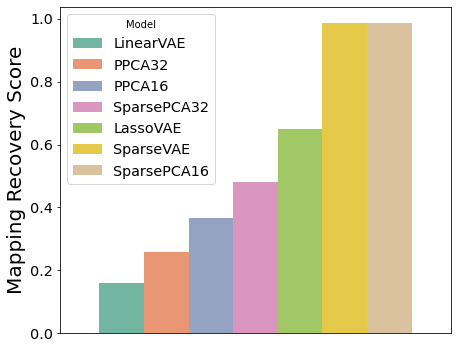

In [13]:
plt.figure(figsize=(7, 6))
metrics["x"] = np.ones(len(metrics))
g=sns.barplot(
    data=metrics, x="x",
    y="mapping_recovery_score",
    hue="Model", palette="Set2", linewidth=10,
)
plt.ylabel("Mapping Recovery Score")
g.axes.get_xaxis().set_visible(False)
g.get_figure().savefig("figures/mapping_recovery_scores.pdf")